# Seattle Airbnb Data Exploration
## The Data
We will be looking at Airbnb listings in the city of Seattle with the goal of practicing data exploration and visualization techniques. Airbnb is a website where owners can list their properties for rental. These rentals are generally marketed for short-term lodging and vacations, but the listings contain a monthly price, so longer term rentals are possible. The data is taken from http://insideairbnb.com/ and contains listings from August 18, 2019. Inside Airbnb collects and organizes data directly from the Airbnb site.

Link to the data: http://data.insideairbnb.com/united-states/wa/seattle/2019-08-18/data/listings.csv.gz

The listings come in a csv file with 9,067 rows and 106 columns. That's a lot of data for each listing, but we will narrow our scope after establishing some questions we'd like to answer.

We will assume the listings are complete, meaning no selection bias as long as we restrict our attention to August 18. That is, we should be wary about extrapolating to other times of the year. Doing so will introduce a temporal bias since there is no guarantee that data taken from one day is representative of the rest of the year.

Unfortunately the data comes without documentation, so we will have to decypher the column names.

## Analytic Questions
1. Which neighborhoods are most common on Airbnb?
2. Which neighborhoods are the priciest?
3. What are some features that affect the rental price of each listing?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
listings = pd.read_csv('listings2019.csv')

C:\Users\henry\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 1. Which neighborhoods are most common on Airbnb?
To address which neighborhoods are most common, let's begin by counting how many listings belong to each neighborhood. One complication is the presence of three different neighborhood columns: 'neighbourhood', 'neighbourhood_cleansed', and 'neighbourhood_group_cleansed.' Since the data came without documentation, it is up to us to decypher the meaning of these columns. Based on the names of the columns, we might expect 'neighbourhood' contains the neighborhood listed on Airbnb, 'neighbourhood_cleansed,' contains what the data collectors at Inside Airbnb believe the neighborhood should be, and 'neighbourhood_group_cleansed,' places each neighborhood in a larger category. Let's take a peak at the few first listings and see if our guess makes sense.

In [3]:
listings[['neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed']].head(15)

,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,Madrona,Madrona,Central Area
1,South Delridge,South Delridge,Delridge
2,Wallingford,Wallingford,Other neighborhoods
3,Georgetown,Georgetown,Other neighborhoods
4,First Hill,First Hill,Downtown
5,The Junction,Fairmount Park,West Seattle
6,The Junction,Fairmount Park,West Seattle
7,Wallingford,Wallingford,Other neighborhoods
8,The Junction,Fairmount Park,West Seattle
9,High Point,High Point,Delridge


Indeed, these listings are consistent with our guess. For example, looking at row 5, the Junction and Fairmount Park are adjacent neighborhoods in West Seattle. The latitude and longitude of the listing in row 5 are 47.55539 and -122.38474, which belongs to Fairmount Park, according to Google Maps, so Inside Airbnb probably made these types of corrections upon scraping the data.

Now that we understand what these columns mean, let's count how many entries are in 'neighbourhood_cleansed' and 'neighbourhood_group_cleansed.'

In [4]:
print('Unique values in neighbourhood_cleansed: {}'.format(listings['neighbourhood_cleansed'].nunique()))
print('Unique values in neighbourhood_group_cleansed: {}'.format(listings['neighbourhood_group_cleansed'].nunique()))

Unique values in neighbourhood_cleansed: 88
Unique values in neighbourhood_group_cleansed: 17


88 is too many neighborhoods to create an useful visual, so thank you to Inside Airbnb for providing the 'neighbourhood_group_cleansed' category.

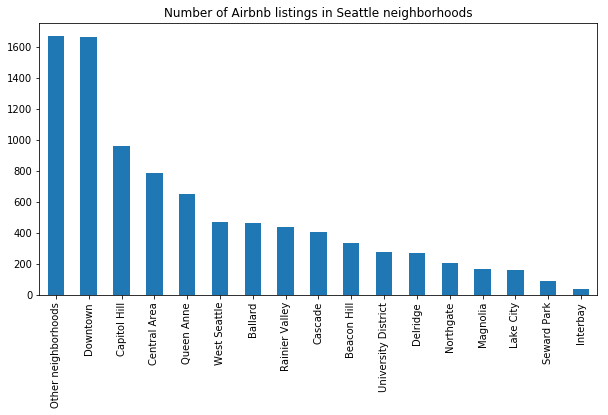

In [5]:
listings['neighbourhood_group_cleansed'].value_counts().plot.bar(figsize=(10,5))
plt.title('Number of Airbnb listings in Seattle neighborhoods')
plt.show()

Ignoring 'Other neighborhoods', we see that most listings are Downtown, followed by Capitol Hill, and then Central Area. The most common category is Other neighborhoods, which doesn't tell us much. Let's take a peak at the 'neighbourhood_cleansed' value counts in listings belonging to the 'Other neighborhoods' category.

In [6]:
listings[listings['neighbourhood_group_cleansed'] == 'Other neighborhoods']['neighbourhood_cleansed'].value_counts()

Wallingford               329
Fremont                   297
Greenwood                 203
Phinney Ridge             141
Green Lake                138
Ravenna                   107
Roosevelt                  85
Bryant                     62
Wedgwood                   51
Bitter Lake                40
Broadview                  36
Crown Hill                 35
Georgetown                 33
North Beach/Blue Ridge     32
Windermere                 27
Laurelhurst                23
View Ridge                 15
South Park                 15
Industrial District         3
Name: neighbourhood_cleansed, dtype: int64

There are neighborhoods in the 'Other neighborhoods' group with more listings than other groups like Interbay and Seward Park, so there are significant neighborhoods hiding in 'Other neighborhoods.' Had I been in charge of designing the 'neighbourhood_group_cleansed' column, I would have made it so all of the neighborhoods in 'Other neighborhoods' have less listings than each of the other neighborhood groups. Let's plot the number of listings for each neighborhood in 'neighbourhood_cleansed,' taking only the 17 largest.

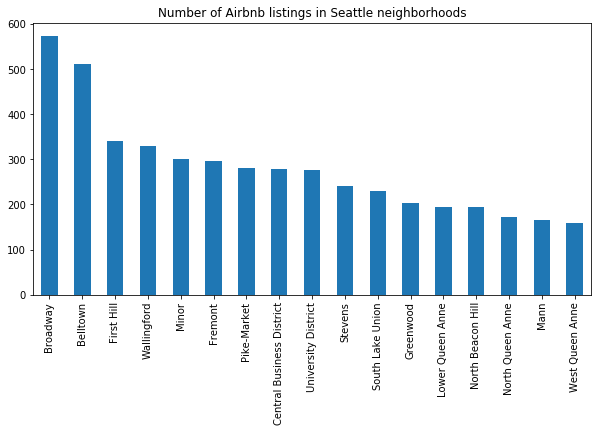

In [7]:
listings['neighbourhood_cleansed'].value_counts()[:17].plot.bar(figsize=(10,5))
plt.title('Number of Airbnb listings in Seattle neighborhoods')
plt.show()

According to this visual, the three most listed neighborhoods are Broadway, Belltown, and First Hill. Belltown and First Hill belong to the Downtown group and Broadway belongs to the Capitol Hill group.

These bar graphs show us that the answer to the question of which neighborhood has the most listings depends on how you chop up the city into neighborhoods. Perhaps a more interesting question would be "which neighborhoods have the most listings relative to the number of dwellings?" This would tell us how likely a place in a given neighborhood is to be listed. Doing so would require us to know how many dwellings exist in each neighborhood, so we'll designate this a future reseach question.

### 2. Which neighborhoods are the priciest?
Next, let's look at how the average rental price varies among neighborhoods. There are three relavent columns: 'price,' 'weekly_price,' and 'monthly_price.' The 'price' column contains the daily price. We will use this column since most Airbnb stays are booked by the day, and only around 10% of listings have weekly or monthly prices. We will inspect both the mean and the median price of listings in each neighborhood.

In [8]:
# clean the price column so we can compute averages
listings['price'] = pd.to_numeric(listings['price'].str.replace('[$,]',''))

# create a new dataframe to aggregate price data
neighborhood_price = listings[['neighbourhood_cleansed','price']].groupby('neighbourhood_cleansed').mean()
neighborhood_price.rename(columns = {'price':'mean'},inplace=True)
neighborhood_price['median'] = listings[['neighbourhood_cleansed','price']].groupby('neighbourhood_cleansed').median()
neighborhood_price.sort_values('median', ascending=False, inplace=True)

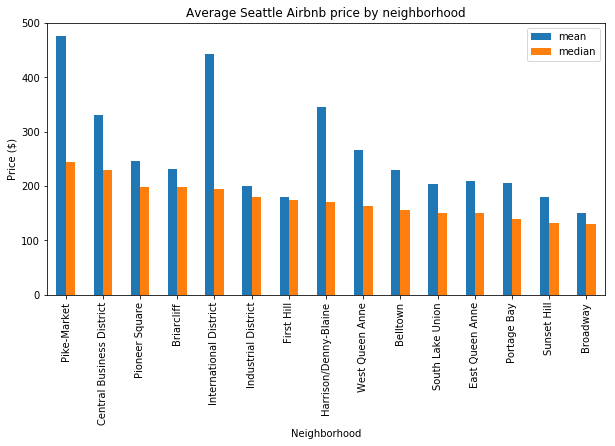

In [9]:
# construct a bar plot
neighborhood_price.head(15).plot.bar(figsize=(10,5))
plt.title('Average Seattle Airbnb price by neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Price ($)')
plt.show()

Ranking the neighborhoods by price depends on whether we average according to the median or the mean. For instance, the Central Business District ranks second by median, but fourth by mean.

The mean of each neighborhood is higher than the median, suggesting right-skewed price data. This is unsuprising because there can be very expensive rentals pulling the mean up, but it's unlikely to find prices close to zero. Because some of the neighborhoods are more skewed than others, it might be interesting to view the shape of the price data by neighborhood with a group of histograms.

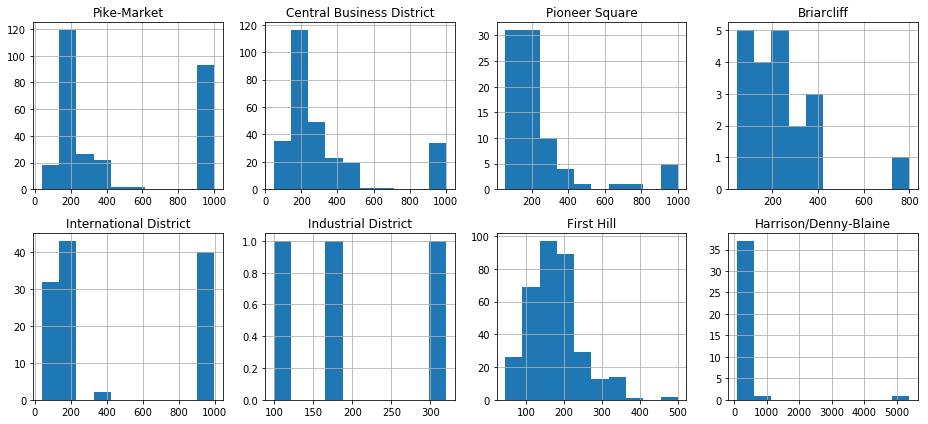

In [10]:
fig=plt.figure(figsize=(13,6))
for i, neighborhood in enumerate(neighborhood_price.index[:8]):
    ax=fig.add_subplot(2,4,i+1)
    listings[listings['neighbourhood_cleansed'] == neighborhood]['price'].hist()
    ax.set_title(neighborhood)
fig.tight_layout()
plt.show()

A few of these histograms look a bit suspicious. For example, Pike-Market, the Central Business District, and the International District all would have an approximately normal distribution centered around \\$200 were it not for an anomolous stack of listings in near \\$1000. Harrison/Denny-Blaine has a very suspicious listing around \\$5000.

In [11]:
# Let's take a peak at the most expensive listings in Pike-Market to get a sense of what's going on.
pd.set_option('display.max_columns', None)
listings[listings['neighbourhood_cleansed'] == 'Pike-Market'].sort_values('price',ascending=False).head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
7724,32925601,https://www.airbnb.com/rooms/32925601,20190818165751,2019-08-18,Downtown Stay Alfred Pike Place,Modern loft-style vacation rental in the Loop ...,With modern exposed brick walls and large wind...,Modern loft-style vacation rental in the Loop ...,none,NaN,NaN,NaN,NaN,We believe in personal space. Prior to your ar...,"1. You're living like a local, be respectful o...",NaN,NaN,https://a0.muscache.com/im/pictures/934488d4-1...,NaN,114353388,https://www.airbnb.com/users/show/114353388,Stay Alfred,2017-02-01,"Spokane, Washington, United States",NaN,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/4587b...,https://a0.muscache.com/im/pictures/user/4587b...,NaN,1545,1545,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Seattle, WA, United States",Pike Place Market,Pike-Market,Downtown,Seattle,WA,98101,Seattle,"Seattle, WA",US,United States,47.61148,-122.34135,f,Apartment,Entire home/apt,4,1.0,1,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Elevator,...",NaN,1002.0,NaN,NaN,$0.00,$0.00,4,$0.00,1,365,1,3,365,365,1.4,365.0,today,t,22,52,82,357,2019-08-18,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,NaN,"{WASHINGTON,"" Seattle"","" WA""}",t,f,strict_14_with_grace_period,f,f,68,68,0,0,NaN
3630,18292286,https://www.airbnb.com/rooms/18292286,20190818165751,2019-08-18,Captivating Stay Alfred on Union Street,"Come home to this upscale 1-bedroom, 1-bath co...",Upscale interior with tall ceilings and modern...,"Come home to this upscale 1-bedroom, 1-bath co...",none,Pike Place,NaN,NaN,Sky Bridge Concierge Courtyard,We believe in personal space. Prior to your ar...,"1. You're living like a local, be respectful o...",NaN,NaN,https://a0.muscache.com/im/pictures/1e46a70d-8...,NaN,114353388,https://www.airbnb.com/users/show/114353388,Stay Alfred,2017-02-01,"Spokane, Washington, United States",NaN,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/4587b...,https://a0.muscache.com/im/pictures/user/4587b...,NaN,1545,1545,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Seattle, WA, United States",Pike Place Market,Pike-Market,Downtown,Seattle,WA,98101,Seattle,"Seattle, WA",US,United States,47.60852,-122.33964,f,Apartment,Entire home/apt,3,1.0,1,2.0,Real Bed,"{TV,""Cable TV"",Internet,W

It turns out that all of the suspicious listings in the Pike-Market neighborhood belong to large startup called Stay Alfred. This company owns a bunch of apartments in the Pike-Market area which it rents on Airbnb in addition to on their own website. Inspecting the rental today (9-17-19) reveals that they typically rent for around \\$140. Hence all of the suspicious listings in our Pike-Market data set are almost certainly the result of a Stay Alfred typo.

In [12]:
# Repeat for Central Business District
listings[listings['neighbourhood_cleansed'] == 'Central Business District'].sort_values('price',ascending=False).head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
5126,22266301,https://www.airbnb.com/rooms/22266301,20190818165751,2019-08-18,Upgraded Stay Alfred on Western Avenue,With huge windows offering awesome Seattle vie...,"More than just a hotel room, this entire apart...",With huge windows offering awesome Seattle vie...,none,Pike Place,NaN,NaN,Two 24-hour fitness and yoga centers Heated sw...,We believe in personal space. Prior to your ar...,"1. You're living like a local, be respectful o...",NaN,NaN,https://a0.muscache.com/im/pictures/bf6e52a0-3...,NaN,114353388,https://www.airbnb.com/users/show/114353388,Stay Alfred,2017-02-01,"Spokane, Washington, United States",NaN,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/4587b...,https://a0.muscache.com/im/pictures/user/4587b...,NaN,1545,1545,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Seattle, WA, United States",Central Business District,Central Business District,Downtown,Seattle,WA,98101,Seattle,"Seattle, WA",US,United States,47.60581,-122.33766,f,Apartment,Entire home/apt,6,2.0,2,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Pool,Kitchen,Gym,...",NaN,1002.0,NaN,NaN,$0.00,$0.00,6,$0.00,1,365,1,3,365,365,1.3,365.0,today,t,17,40,67,338,2019-08-18,5,3,2018-04-08,2019-06-12,76.0,8.0,10.0,9.0,10.0,10.0,8.0,t,NaN,"{WASHINGTON,"" Seattle"","" WA""}",t,f,strict_14_with_grace_period,f,f,68,68,0,0,0.30
5125,22266079,https://www.airbnb.com/rooms/22266079,20190818165751,2019-08-18,Unique Stay Alfred on Western Avenue,With huge windows offering awesome Seattle vie...,"More than just a hotel room, this entire apart...",With huge windows offering awesome Seattle vie...,none,Pike Place,NaN,NaN,Two 24-hour fitness and yoga centers Heated sw...,We believe in personal space. Prior to your ar...,"1. You're living like a local, be respectful o...",NaN,NaN,https://a0.muscache.com/im/pictures/8ae348b5-1...,NaN,114353388,https://www.airbnb.com/users/show/114353388,Stay Alfred,2017-02-01,"Spokane, Washington, United States",NaN,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/4587b...,https://a0.muscache.com/im/pictures/user/4587b...,NaN,1545,1545,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Seattle, WA, United States",Central Business District,Central Business District,Downtown,Seattle,WA,981

Same situation. A collection of \\$999 Stay Alfred listings. Probably a typo.

In [13]:
# Pioneer Square
listings[listings['neighbourhood_cleansed'] == 'Pioneer Square'].sort_values('price',ascending=False).head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
8165,34365876,https://www.airbnb.com/rooms/34365876,20190818165751,2019-08-18,Cozy 1 BR Condo in Seattle,"Unbeatable location! Our stylish 1-bedroom, pe...",Just some of the premium services in your suit...,"Unbeatable location! Our stylish 1-bedroom, pe...",none,FOR YOUR EVERYDAY GROCERY ITEMS AND DAILY NEED...,PARKING Private parking is available on site ...,NaN,Our guests enjoy access to: •Business center f...,Guest satisfaction is very important to us. O...,- 1) Due to previous problems (and we’re sure ...,NaN,NaN,https://a0.muscache.com/im/pictures/48fcb46a-f...,NaN,222592495,https://www.airbnb.com/users/show/222592495,Executive Stay Inc Seattle,2018-10-25,CA,NaN,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/44a31...,https://a0.muscache.com/im/pictures/user/44a31...,International District,52,52,"['email', 'phone', 'reviews']",t,f,"Seattle, WA, United States",Pioneer Square,Pioneer Square,Downtown,Seattle,WA,98104,Seattle,"Seattle, WA",US,United States,47.60206,-122.33162,f,Apartment,Entire home/apt,3,1.0,1,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",""Wheelcha...",NaN,999.0,NaN,NaN,NaN,NaN,4,$0.00,2,1125,2,3,1125,1125,2.0,1125.0,today,t,17,36,53,328,2019-08-18,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,27-2019869,"{WASHINGTON,"" Seattle"","" WA""}",t,f,strict_14_with_grace_period,f,f,52,52,0,0,NaN
8143,34313962,https://www.airbnb.com/rooms/34313962,20190818165751,2019-08-18,Executive 2BR Rental Apartment in Seattle,The finest and most unique accommodation in Se...,Several schools are located nearby including t...,The finest and most unique accommodation in Se...,none,80 S Main St is a multi-family home in Seattle...,Parking No parking available. Pets Pets are al...,NaN,NaN,NaN,OUR HOUSE RULES: - 1) Due to previous problem...,NaN,NaN,https://a0.muscache.com/im/pictures/cd28fc85-4...,NaN,222592495,https://www.airbnb.com/users/show/222592495,Executive Stay Inc Seattle,2018-10-25,CA,NaN,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/44a31...,https://a0.muscache.com/im/pictures/user/44a31...,International District,52,52,"['email', 'phone', 'reviews']",t,f,"Seattle, WA, United States",Pioneer Square,Pioneer Square,Downtown,Seattle,WA,98104,Seattle,"Seattle, WA",US,United State

Same situation once again, except the culprit this time is Executive Stay Inc. They have a group of listings priced at \\$999 while their current price is in the \\$100 range. Continuing on in this manner, we find that all of the listings in the top eight neighborhoods above \\$800 dollars are likely the result of typos. One thing we could do to improve our analysis is just purge the data of any listings over \\$800. This is a bit of a ham handed solution, however, because it would throw out any sufficiently expensive legitimate properties if they exist. Furthermore, there may be typos below \\$800. Let's go ahead and do it anyway. The presence of a bunch of large false values is more misleading than the absence of a few true ones.

Had we not caught the typos, our analysis of the priciest neighborhoods may have been compromised. It was wise to produce our intitial ranking with the median, as it is a more robust measure of center in the presence of noise.

Note: It turns out that there really are some legitimate listings that go well over \\$800. Finding a better method for cleaning the price column is a good future research project.

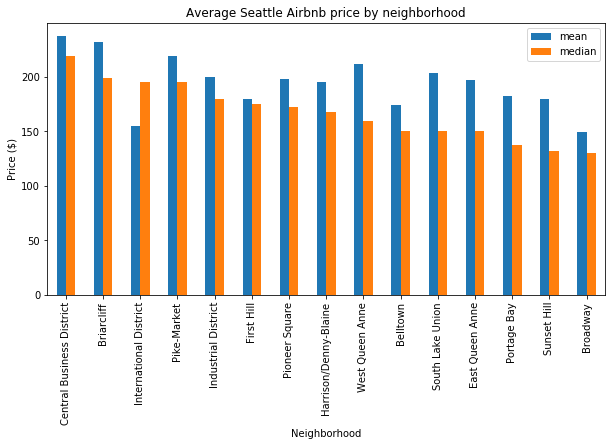

In [14]:
listings_cleaned = listings[listings['price']<=800]

# create a new dataframe to aggregate price data
neighborhood_price_cleaned = listings_cleaned[['neighbourhood_cleansed','price']].groupby('neighbourhood_cleansed').mean()
neighborhood_price_cleaned.rename(columns = {'price':'mean'},inplace=True)
neighborhood_price_cleaned['median'] = listings_cleaned[['neighbourhood_cleansed','price']].groupby('neighbourhood_cleansed').median()
neighborhood_price_cleaned.sort_values('median', ascending=False, inplace=True)

# construct a bar plot
neighborhood_price_cleaned.head(15).plot.bar(figsize=(10,5))
plt.title('Average Seattle Airbnb price by neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Price ($)')
plt.show()

Excising the suspicious listings has actually modified our rankings. Now the top three are Central Business District, Briarcliff, and International District. Formerly, they were Pike-Market, Central Business District, and then Pioneer Square.

In addition to cleaning the data more intelligently, one thing we could do in the future to make our conclusions more rigorous is throw out the neighborhoods which have less than say 20 entries. For example, the International District only has three listings, so that price data may not be representative.

### 3. What are some features that affect the rental price of each listing?
We've seen that the location of the property affects the price of the listing. Let's explore some other features that may affect price. There are 106 columns and many of them are irrelavent to this question, e.g., listing_url, last_scraped, thumbnail_url. We will begin by manually searching through the columns and selecting a subset that might be interesting to compare to price. There are some features, like 'number_of_reviews' and 'availability_365,' which may be affected by price rather than vice versa, so let's broaden our search to features that are correlated with price without worrying about the direction of causation.

The selection of columns: acommodates, property_type, number_of_reviews, availability_365.

Square_feet is likely to affect price, but alas, over 95% of the listings are missing it.

Also, there are some columns containing string data, like 'name,' 'summary,' and 'space,' which could probably be connected to price. However, doing so would require some natural language processing and is beyond the scope of this report. Just for fun, let's construct a column containing the length of 'rules.' Maybe pricier properties are more likely to have more rules!

In [15]:
# create the rule_length column

listings_cleaned.loc[listings_cleaned['house_rules'].isna(),'house_rules'] = ''
listings_cleaned['rule_length'] = listings_cleaned['house_rules'].apply(len)

C:\Users\henry\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


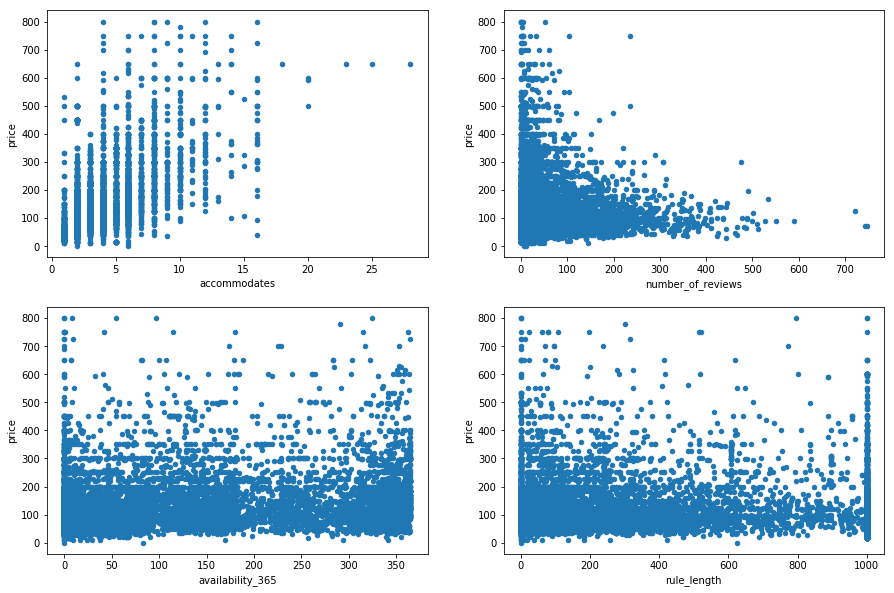

In [16]:
# plotting acommodates, number_of_review, availabililty_365, and rule_length against price

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(2,2,1)
listings_cleaned.plot.scatter('accommodates','price',ax=ax)

ax = fig.add_subplot(2,2,2)
listings_cleaned.plot.scatter('number_of_reviews','price',ax=ax)

ax = fig.add_subplot(2,2,3)
listings_cleaned.plot.scatter('availability_365','price',ax=ax)

ax = fig.add_subplot(2,2,4)
listings_cleaned.plot.scatter('rule_length','price',ax=ax)

plt.show()

'Accommodates' seems to show the clearest correlation to price. This shouldn't be a surprise. Listings that accommodate more people tend to cost more. The 'number_of_reviews' column is a bit trickier. There appears to be a pinching effect where as you move right along the x-axis, the price range narrows. It's hard to say whether it's because lower price correlates with more reviews (maybe cheaper listings are rented more often, leading to more reviews) or because there are just less listings in the higher price ranges, making the top of the graph more bare. I wonder if taking random samples from each price range before plotting to ensure there are an equal number of data points on each vertical band would yield better insight. Furthermore, number_of_reviews could just be a proxy for number of times a listing has been rented. Our data set doesn't contain this data.

'Availability_365' and 'rule_length' don't seem to correlate with price.

We can confirm our visual inspection of the scatter plots by computing the correlation coefficient for each. Doing so reveals that the only significant (linear) correlation is indeed 'accommodates.'

In [17]:
listings_cleaned[['accommodates','number_of_reviews','availability_365','rule_length','price']].corr()

,accommodates,number_of_reviews,availability_365,rule_length,price
accommodates,1.000000,-0.041041,0.036553,0.118010,0.598872
number_of_reviews,-0.041041,1.000000,0.089109,0.096768,-0.151230
availability_365,0.036553,0.089109,1.000000,0.219486,0.112598
rule_length,0.118010,0.096768,0.219486,1.000000,0.091678
price,0.598872,-0.151230,0.112598,0.091678,1.000000


Lastly, let's investigate whether the property_type column is connected to price.

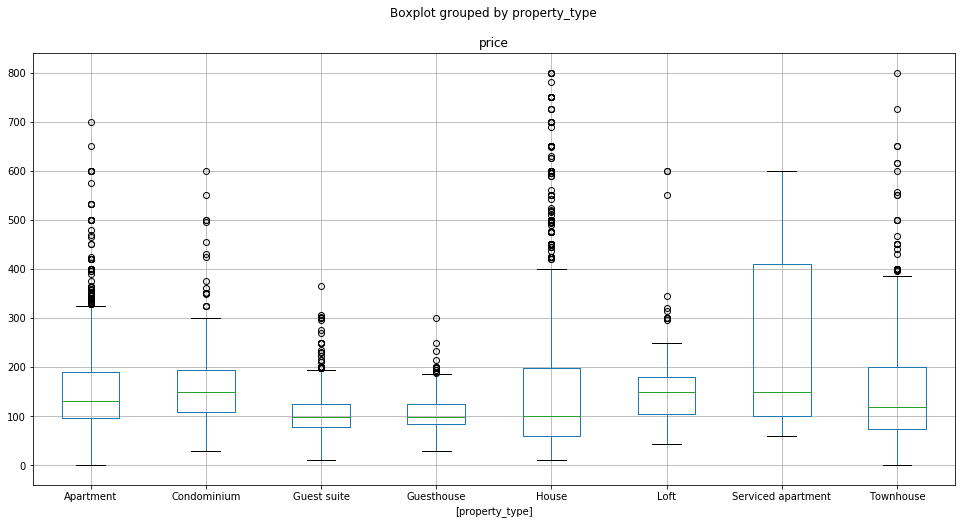

In [18]:
# grab the most common property types
common_property_types = listings_cleaned['property_type'].value_counts().head(8).index

listings_cleaned.loc[listings_cleaned['property_type'].isin(common_property_types)][['property_type','price']].boxplot(by='property_type',figsize=(16,8))
plt.show()

Property_type clearly influences price. For example, we see the median price of a apartments and condos is higher than that of houses. Furthermore, serviced apartment prices are more spread out than, say, guesthouses. Once again, I wonder if caution should be taken comparing these box plots because the further to the one goes, the more price data is available.

### Further Research
To reiterate some ideas for future research:
1. We could answer which neighborhood contains the dwellings most likely to be listed by researching the population of each neighborhood and comparing to the number of Airbnb listings by neighborhood.
2. We could do a better job of answering which neighborhoods are priciest by cleaning the data more intelligently. More specificly, we could devise a method of detecting typos in the price data.
3. We could see if string data like 'name,' 'summary,' and 'space' correlate with price using natural languate processing techniques.